<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


# Registration of an Image Stack
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/Register_Image_Stack.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/Register_Image_Stack.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into registration of an image stack.

This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.8.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade
    
if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
    !{sys.executable} -m pip install simpleitk
# ------------------------------
print('done')

done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../..')
%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    
# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2023_1_20'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2023.8.1


## Open File

### Choose Mode of  File Selection


The FileWidget will use display the name of a Nion File like in NionSwift. 

Select a main dataset and any additional data like reference data and such.

In [3]:
fileWidget = ft.FileWidget()

### Load File

If you did not choose the file widget a File Dialog window will open in the next code cell.

Otherewise just select a File in the widget above

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

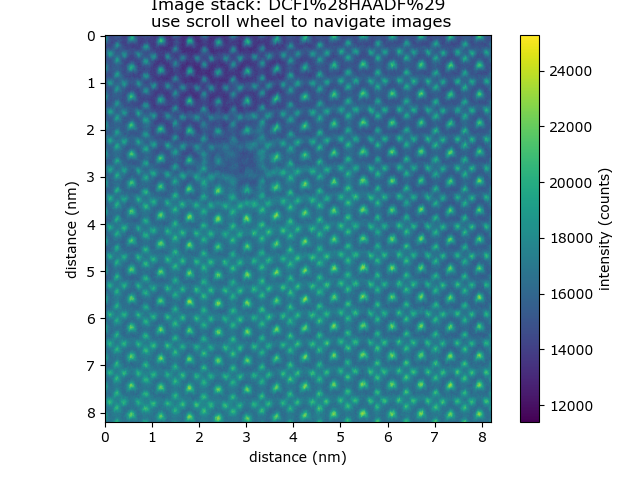

In [6]:
datasets = fileWidget.datasets
dataset = datasets['Channel_000']

if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need an image here')

view = dataset.plot()

## First: Rigid Registration

If this is an image stack we need to register and add the images. 

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 

In [7]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: DCFI%28HAADF%29', 'Channel_001: HAADF'), value=…

Stack contains  20  images, each with 1024  pixels in x-direction and  1024  pixels in y-direction


  0%|          | 0/20 [00:00<?, ?it/s]

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<rechunk-merge, shape=(20, 982, 1006), dtype=float64, chunksize=(16, 982, 1006), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
frame:  time (frame) of size (20,)
x:  distance (nm) of size (982,)
y:  distance (nm) of size (1006,)
 with metadata: ['analysis', 'drift', 'input_crop', 'input_shape']

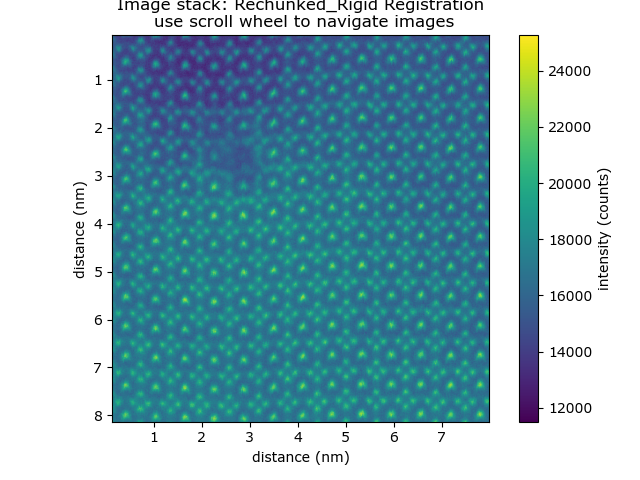

In [8]:
rig_reg_dataset = it.rigid_registration(chooser.dataset)

view = rig_reg_dataset.plot()
rig_reg_dataset

### Determine Quality of Rigid Registration

First we fit a polynom of degree **polynom_degree** onto the drift of x and y separately.

The Nion STEMs are extremly stable and sub_pixel drift per image can be achieved.

A pixel of size 30pm distributed over 512 pixel (the size of many images) is obviously negletible.

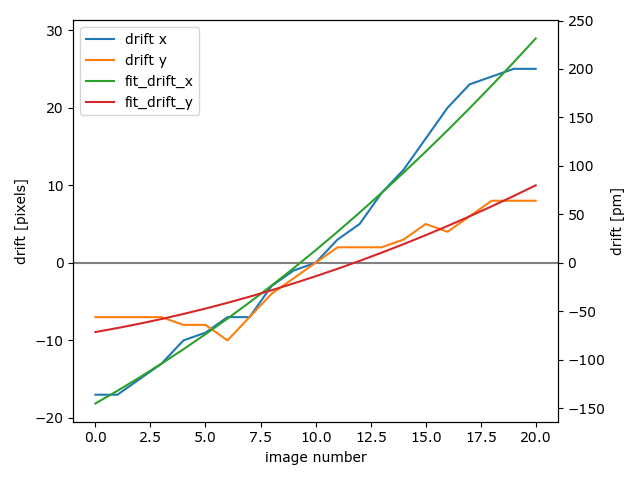

In [9]:
scale_x = ft.get_slope(rig_reg_dataset.x.values)*1000.
drift = rig_reg_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.08


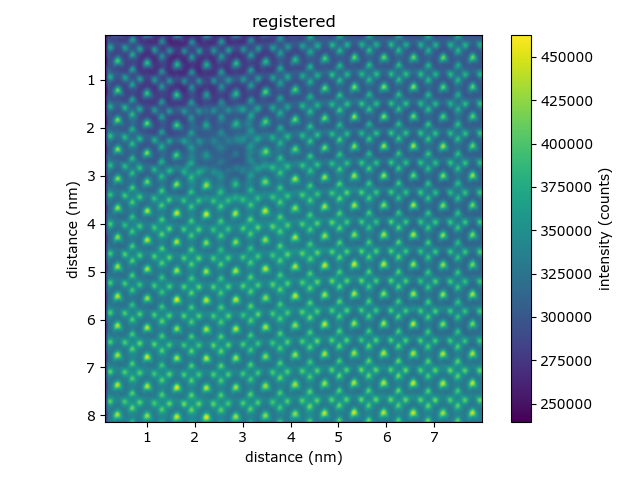

In [10]:
image = rig_reg_dataset.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'

image.set_dimension(0,rig_reg_dataset.dim_1)
image.set_dimension(1,rig_reg_dataset.dim_2)
print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view =image.plot()


### Log Rigid Registration

We store the croped image-stack and drift-data here.

In [11]:
datasets['Log_000'] = image.copy()


## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

In [ ]:
non_rigid_registered = it.demon_registration(rig_reg_dataset)

view = non_rigid_registered.plot()

  0%|          | 0/20 [00:00<?, ?it/s]

### Contrast
The image should have improved in contrast and signal noise ratio.

In [ ]:
image = non_rigid_registered.sum(axis=0)
image.data_type = 'image'
image.title = 'registered'
image.set_dimension(0,non_rigid_registered.dim_1)
image.set_dimension(1,non_rigid_registered.dim_2)

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

view = image.plot()

### Log Non-Rigid Registration

In [ ]:
datasets['Log_001'] = non_rigid_registered

A tree-like plot of the file

## Comparison of Different Dataset

A convenient function to select a dataset (for further processing, visualization or whatever)

In [27]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'Log_001: Non-…

The selected dataset can then easily be plotted

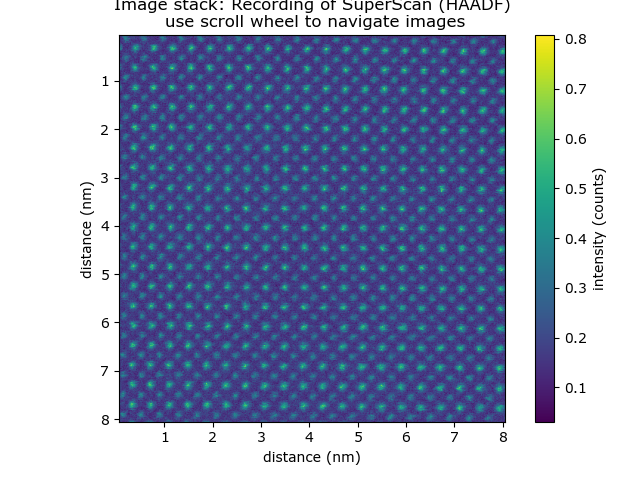

In [28]:
view = chooser.dataset.plot()

## Save File
let's save the datasets

In [29]:
h5_group = ft.save_dataset(datasets, filename=dataset.metadata['filename'])

Cannot overwrite file. Using:  STO-stack-1.hf5


C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:Non-Rigid Registration to Non_Rigid Registration
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may 

In [30]:
print('original file ', dataset.metadata['filename'])
print('was saved to: '+ h5_group.file.filename)

original file  C:\Users\gduscher\Documents\Github\Image_Distortion\STO-stack.h5
was saved to: C:\Users\gduscher\Documents\Github\Image_Distortion\STO-stack-1.hf5


Please note, that the file is still open, so we need to close it.

In [31]:
h5_group.file.close()

## Find Atom Positions
### Lucy -Richardson Deconvolution

Lucy - Richardson Deconvolution removes noise and convolutes the intensity back into the atom (columns).

Here we use a slightly modified Lucy - Richardson Deconvolution which stops when converged.

Ideally the atom_size should be as large as the atoms in the image.

A good Lucy-Richardson Deconvolution should result in an image with atoms of a radius of about 2 pixels.

The number of steps to convergence should be less than 300 for a good approximation of atom_size.


In [43]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'Log_001: Non-…

Contrast = 0.38
Deconvolution of  Non-Rigid Registration


  0%|          | 0/500 [00:00<?, ?it/s]

terminate
converged in 501 iterations

 Lucy-Richardson deconvolution converged in 501  iterations


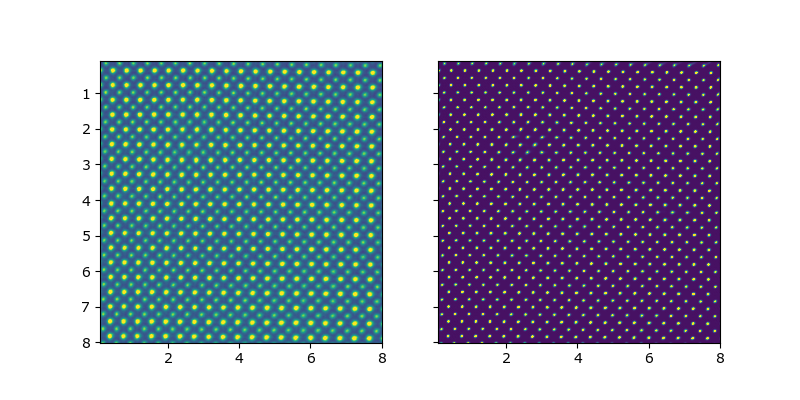

In [62]:
# ------- Input ------
atoms_size = 0.09 # in nm
# --------------------
import pyTEMlib.probe_tools
image = chooser.dataset

dataset = chooser.dataset
if dataset.ndim >2:
    image = dataset.sum(axis=0)
else:
    image = dataset
image.data_type = 'image'
image.title = 'registered'

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

out_tags = {}
image.metadata['experiment']= {'convergence_angle': 30, 'acceleration_voltage': 200000.}

scale_x = ft.get_slope(image.dim_0)
gauss_diameter = atoms_size/scale_x
gauss_probe = pyTEMlib.probe_tools.make_gauss(image.shape[0], image.shape[1], gauss_diameter)

print('Deconvolution of ', dataset.title)
LR_dataset = it.decon_lr(image, gauss_probe, verbose=False)

extent = LR_dataset.get_extent([0,1])
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image[:500,:500].T, extent = extent,vmax=np.median(np.array(image))+3*np.std(np.array(image)))
ax[1].imshow(LR_dataset[:500,:500].T, extent = extent, vmax=np.median(np.array(LR_dataset))+3*np.std(np.array(LR_dataset)));


In [64]:
LR_dataset.metadata = {'analysis': 'Lucy_Richardson',
                        'name': 'Lucy_Richardson',
                        'notebook': __notebook__ ,
                        'notebook_version': __notebook_version__,
                        'input': dataset.title,
                        'probe_diameter': gauss_diameter,
                        'kind_of_probe': 'Gauss',
                        'probe_width': atoms_size
                        }
                          
datasets['LR_deconvolution'] = LR_dataset

### Blob Detection

Choose threshold and atom size so that all atoms or at least all bright atoms of an unit cell are found 

791


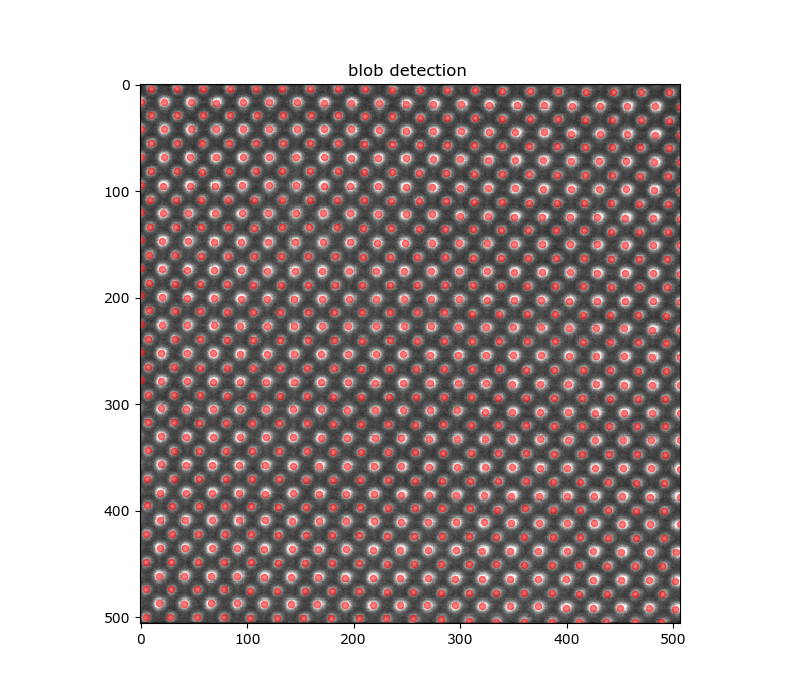

In [70]:
# ------- Input ------
threshold = 1. #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = .06 #in nm  
# ----------------------
import skimage
scale_x = ft.get_slope(image.dim_1)
blobs =  skimage.feature.blob_log(image, max_sigma=atom_size/scale_x, threshold=threshold)
print(len(blobs))
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

In [72]:
datasets['atom_finding'] = {'analysis': 'Atom Positions with blob finder',
                            'notebook': __notebook__,
                            'notebook_version': __notebook_version__,
                            'atoms': blobs,
                            
                            'atom_size': atom_size, #in nm gives the size of the atoms or resolution
                            'threshold':  threshold, 
                            'pixel_size': scale_x,
                            'name': 'Atom finding',
                            'title': 'Atom finding'}
            

In [74]:
chooser = ft.ChooseDataset(datasets)  

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'LR_deconvolut…

In [80]:
dataset = chooser.dataset
if dataset.ndim >2:
    image = dataset.sum(axis=0)
    image.data_type = 'image'
    image.title = 'registered'
else:
    image = dataset

atoms = datasets['atom_finding']['atoms']
image = image-image.min()
print(image)

sidpy.Dataset of type IMAGE with:
 dask.array<sub, shape=(507, 506), dtype=float64, chunksize=(507, 506), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
y:  distance (nm) of size (507,)
x:  distance (nm) of size (506,)
 with metadata: ['analysis', 'input_crop', 'input_shape', 'input_dataset', 'experiment']


using radius  2 pixels


  0%|          | 0/791 [00:00<?, ?it/s]

C:\Users\gduscher\Documents\Github\pyTEMlib\notebooks\Imaging\../..\pyTEMlib\probe_tools.py:13: RuntimeWarning: invalid value encountered in divide
  probe = g / g.sum() * intensity


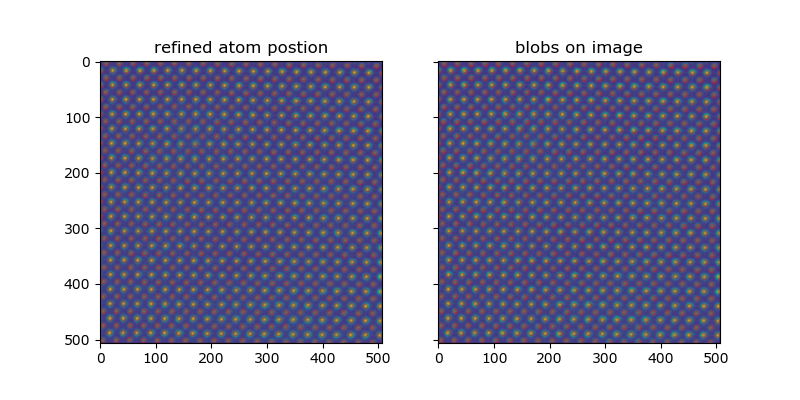

In [85]:
import pyTEMlib.atom_tools
atom_radius = 2
MaxInt = 0
MinInt = 0 
maxDist = 2
sym = pyTEMlib.atom_tools.atom_refine(np.array(image), atoms, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,0],refined_atoms[:,1],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

In [86]:
datasets['atom_refinement'] = sym.copy()
datasets['atom_refinement']['name'] = 'refined_atom_positions'
datasets['atom_refinement']['radius'] = atom_radius
datasets['atom_refinement']['MaxInt'] = MaxInt
datasets['atom_refinement']['MinInt'] = MinInt
datasets['atom_refinement']['maxDist'] = maxDist

datasets['atom_refinement']['analysis']= 'Atom Position Refinement'
datasets['atom_refinement']['notebook']= __notebook__ 
datasets['atom_refinement']['notebook_version']= __notebook_version__

datasets['atom_refinement']['input']= dataset.title

datasets['atom_refinement']['name'] = 'Atom refinement'
datasets['atom_refinement']['title'] = out_tags['name']

atom_channel = datasets['atom_refinement']

